# 

# BGC Argo
Chloe Cheng

Opening Argo data downloaded from https://fleetmonitoring.euro-argo.eu/float/6902909. To download: click the NetCDF download button under 'Stations Data' and enter email. In my experience, the link took a few days to arrive.

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import gsw

In [124]:
ds_argo = xr.open_dataset('bgc_argo/GL_PR_PF_6902909.nc')
ds_argo = ds_argo.rename_dims({'DEPTH': 'depth_index'}) # DEPTH variable is not actual depth in meters 
ds_argo

<xarray.Dataset>
Dimensions:                   (TIME: 1501, LATITUDE: 1501, LONGITUDE: 1501,
                               POSITION: 1501, depth_index: 1932)
Coordinates:
  * TIME                      (TIME) datetime64[ns] 2019-03-01T05:30:00 ... 2...
  * LATITUDE                  (LATITUDE) float32 -8.85 -8.85 ... -8.167 -8.167
  * LONGITUDE                 (LONGITUDE) float32 -140.6 -140.6 ... -142.2
Dimensions without coordinates: POSITION, depth_index
Data variables: (12/46)
    TIME_QC                   (TIME) float32 ...
    POSITION_QC               (POSITION) float32 ...
    DC_REFERENCE              (TIME) object ...
    DIRECTION                 (TIME) object ...
    VERTICAL_SAMPLING_SCHEME  (TIME) object ...
    PRES                      (TIME, depth_index) float32 ...
    ...                        ...
    DOWN_IRRADIANCE412        (TIME, depth_index) float64 ...
    DOWN_IRRADIANCE412_QC     (TIME, depth_index) float32 ...
    DOWN_IRRADIANCE490        (TIME, depth_index) float64 ...
    DOWN_IRRADIANCE490_QC     (TIME, depth_index) float32 ...
    LGHT                      (TIME, depth_index) float64 ...
    LGHT_QC                   (TIME, depth_index) float32 ...
Attributes: (12/49)
    data_type:                      OceanSITES vertical profile
    format_version:                 1.4
    platform_code:                  6902909
    institution:                    Laboratory of Oceanography of Villefranche
    institution_edmo_code:          490
    site_code:                       
    ...                             ...
    last_date_observation:          2024-04-09T01:46:00Z
    last_latitude_observation:      -8.16725
    last_longitude_observation:     -142.24309
    date_update:                    2024-04-19T06:49:52Z
    history:                        2024-04-19T06:49:52Z : Creation
    data_mode:                      M

In [79]:
# calculate depth from pressure using gsw

def get_depth_from_ds(ds):
    latitude_like_depth = np.zeros(ds.PRES.shape)
    for i in range(latitude_like_depth.shape[1]):
        latitude_like_depth[:,i] = ds.LATITUDE.values
    depth = gsw.z_from_p(ds.PRES, latitude_like_depth)
    depth = depth.rename('DEPTH').assign_attrs({
        'standard_name': 'depth', 
        'long_name': 'Depth',
        'units': 'm',
        'ancillary_variables': ''
    })

    return depth

## Cleaning

The original dataset contains a lot of nans, so here we clean it by dropping data where every chlorophyll arrays where every time value is nan.

In [206]:
ds_clean = ds_argo.dropna(dim='TIME', how='all', subset=['CPHL_ADJUSTED'])  # there are a lot of only-NaN times we need to drop

# create a boolean array mask for missing chlorophyll data and subset other variables too 
missing_data_mask = np.isnan(ds_argo.CPHL_ADJUSTED).sum(dim='depth_index') != len(ds_argo.depth_index)
ds_clean['LATITUDE'] = ds_clean.LATITUDE[missing_data_mask.values]
ds_clean['LONGITUDE'] = ds_clean.LONGITUDE[missing_data_mask.values]

# POSITION is simply an index in the time coordinate so we remove it 
ds_clean = ds_clean.drop_dims('POSITION') 

# now, calculate the real depth using gsw
depth_true = get_depth_from_ds(ds_clean)

(218, 1932)


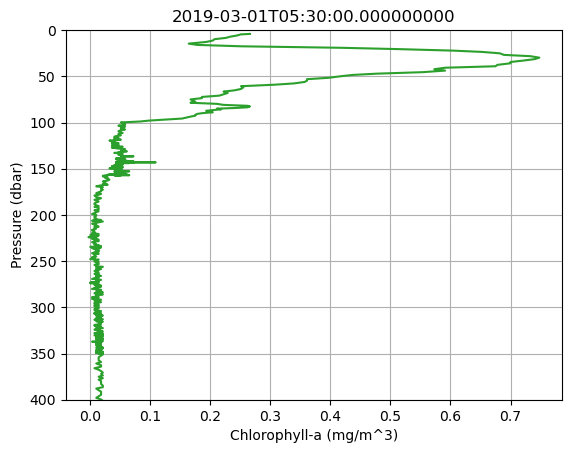

In [19]:
chla_sample = ds_clean.CPHL_ADJUSTED[0]
pressure_sample = ds_clean.PRES[0]

plt.plot(chla_sample, pressure_sample, color='tab:green')
plt.gca().invert_yaxis()
plt.ylabel('Pressure (dbar)')
plt.xlabel('Chlorophyll-a (mg/m^3)')
plt.ylim(400,0)
plt.title(ds_clean.TIME[0].values)
plt.grid()
plt.savefig('figures/chlorophyll_profile.png', dpi=300, bbox_inches='tight')

## Deep Chlorophyll Max

/var/folders/3n/bmln3m1s2b15c_dvp93gxmlr0000gn/T/ipykernel_94001/4192527618.py:10: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  plt.pcolormesh(ds_clean.TIME, -depths_zero_mask.T, chlorophyll.values.T,


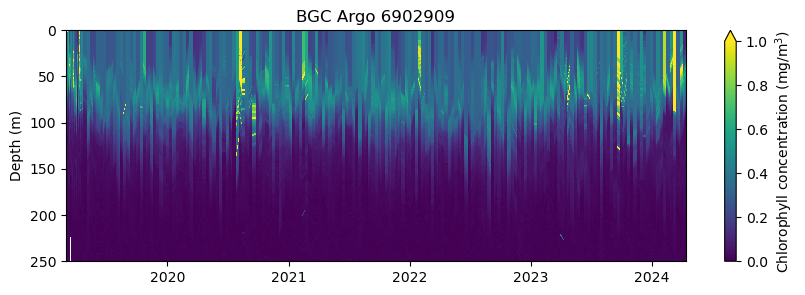

In [207]:
chlorophyll = ds_clean.CPHL_ADJUSTED

# try make nans to 0 (filler value)
nan_depths = np.isnan(depth_true).values.flatten()
depths_flattened = depth_true.values.flatten() 
depths_flattened[nan_depths] = 0 
depths_zero_mask = depths_flattened.reshape(depth_true.shape)

plt.figure(figsize=(10,3))
plt.pcolormesh(ds_clean.TIME, -depths_zero_mask.T, chlorophyll.values.T, 
                vmin=0, vmax=1)
plt.ylim(0,250)

# Invert the y-axis
plt.gca().invert_yaxis()
plt.title('BGC Argo 6902909')
plt.ylabel('Depth (m)')
cbar = plt.colorbar(extend='max')
cbar.set_label(r'Chlorophyll concentration (mg/m$^3$)')
plt.savefig('figures/argo_chl_depth_time.jpg', dpi=300, bbox_inches='tight')

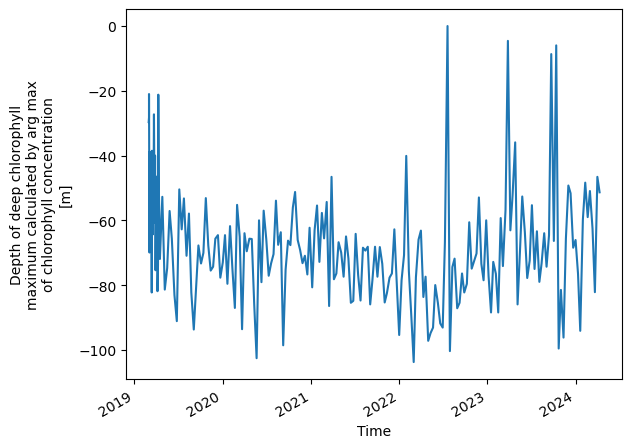

In [223]:
# here we define the DCM simply by the argmax of chlorophyll concentration 
depth_of_dcm_via_argmax = depth_true.isel(depth_index=chlorophyll.argmax(dim='depth_index'))
depth_of_dcm_via_argmax = depth_of_dcm_via_argmax.assign_attrs({
        'standard_name': 'depth of DCM via argmax', 
        'long_name': 'Depth of deep chlorophyll maximum calculated by arg max of chlorophyll concentration',
        'units': 'm',
        'ancillary_variables': ''
    })

depth_of_dcm_via_argmax.plot()

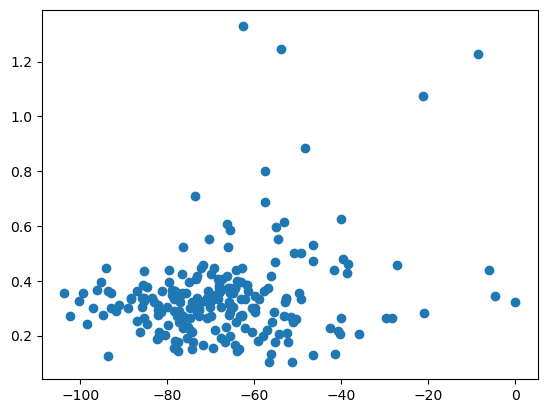

In [227]:
plt.scatter(depth_of_dcm_via_argmax, chlorophyll.isel(depth_index=0))

In [67]:
ds_clean_temp = ds.dropna(dim='DEPTH', how='all', subset=['TEMP'])  # there are a lot of only-NaN times we need to drop
ds_clean_temp

<xarray.Dataset>
Dimensions:                   (TIME: 1501, LATITUDE: 1501, LONGITUDE: 1501,
                               POSITION: 1501, DEPTH: 232)
Coordinates:
  * TIME                      (TIME) datetime64[ns] 2019-03-01T05:30:00 ... 2...
  * LATITUDE                  (LATITUDE) float32 -8.85 -8.85 ... -8.167 -8.167
  * LONGITUDE                 (LONGITUDE) float32 -140.6 -140.6 ... -142.2
Dimensions without coordinates: POSITION, DEPTH
Data variables: (12/46)
    TIME_QC                   (TIME) float32 ...
    POSITION_QC               (POSITION) float32 ...
    DC_REFERENCE              (TIME) object ...
    DIRECTION                 (TIME) object ...
    VERTICAL_SAMPLING_SCHEME  (TIME) object ...
    PRES                      (TIME, DEPTH) float32 ...
    ...                        ...
    DOWN_IRRADIANCE412        (TIME, DEPTH) float64 ...
    DOWN_IRRADIANCE412_QC     (TIME, DEPTH) float32 ...
    DOWN_IRRADIANCE490        (TIME, DEPTH) float64 ...
    DOWN_IRRADIANCE490_QC     (TIME, DEPTH) float32 ...
    LGHT                      (TIME, DEPTH) float64 ...
    LGHT_QC                   (TIME, DEPTH) float32 ...
Attributes: (12/49)
    data_type:                      OceanSITES vertical profile
    format_version:                 1.4
    platform_code:                  6902909
    institution:                    Laboratory of Oceanography of Villefranche
    institution_edmo_code:          490
    site_code:                       
    ...                             ...
    last_date_observation:          2024-04-09T01:46:00Z
    last_latitude_observation:      -8.16725
    last_longitude_observation:     -142.24309
    date_update:                    2024-04-19T06:49:52Z
    history:                        2024-04-19T06:49:52Z : Creation
    data_mode:                      M

# Binning 
Author: Yuchen Li
Date: 5/1/24

In [73]:
def plot_map(data, dir='', save=False, time_as_title=True, title=''):
    plt.figure(figsize=(8,7))
    ax = plt.subplot(2,1, 1, projection=ccrs.PlateCarree())
    im = ax.pcolormesh(data.lon, data.lat, np.squeeze(data.values), 
                       vmin=0, vmax=2, cmap='Spectral_r', transform=ccrs.PlateCarree())
    if time_as_title:
        if 'time' in data.dims: 
            date = np.datetime_as_string(data.time.values, unit='D')
            plt.title(date)
        else:
            ValueError('dataarray does not have time dimension')
    else:
        plt.title(title)

    ax.coastlines()
    ax.set_xticks(np.linspace(-146, -134, 7), crs=ccrs.PlateCarree())
    ax.set_yticks(np.linspace(-13, -6, 8), crs=ccrs.PlateCarree())

    # draw bounding box
    x_min, x_max = -142, -138
    y_min, y_max = -11, -8
    rect = plt.Rectangle((x_min, y_min), x_max - x_min, y_max - y_min,
                        linewidth=1, edgecolor='w', facecolor='none')
    plt.gca().add_patch(rect)

    cbar = plt.colorbar(im, orientation='vertical')
    cbar.set_label(fr'Chlorophyll (mg/m$^3$)')
    if save and time_as_title:
        plt.savefig(f'{dir}/{date}.jpg', dpi=300, bbox_inches='tight')
        plt.close()
    else: plt.show()

ds = xr.open_dataset('../data/chlorophyll/ChlA_19970906-20240329_GSM.nc')
chla = ds.CHL1_mean

chla_region = chla.sel(lat=slice(-8, -11), lon=slice(-142, -138))

# take the area-weighted average
weights = np.cos(np.deg2rad(chla_region.lat))
chla_naive_avg = chla_region.weighted(weights).mean(dim=['lat', 'lon'])

# if there is not enough data, remove 
nan_counts = chla_region.isnull().sum(dim=('lat', 'lon'))
total_points = np.size(chla_region[0])

# threshold for greatest allowed proportion of missing data 
thresh = 0.3
missing_data_mask = nan_counts/total_points <= thresh
chla_avg = chla_naive_avg.where(missing_data_mask, other=np.nan)

# calculate a rolling average with a window of 12 months
chla_smooth = chla_naive_avg.rolling(time=12, center=True).mean()

In [121]:
ds_argo = ds_argo.dropna(dim='TIME', how='all')

argo_time = ds_argo.TIME 

# find the closest time in the argo dataset to the time in the chlorophyll dataset
nearest_indices = np.abs(np.subtract.outer(argo_time.values,chla.time.values)).argmin(axis=1)
argo_matched_to_chla_times = chla.time[nearest_indices]

argo_matched_to_chla_times
chla_region.sel(time=argo_matched_to_chla_times[0], 
                lat=ds_argo.LATITUDE[0],
                lon=ds_argo.LONGITUDE[0], method='nearest')

<xarray.DataArray 'CHL1_mean' ()>
array(0.314211, dtype=float32)
Coordinates:
    lat        float32 -8.854
    lon        float32 -140.6
    time       datetime64[ns] 2019-02-26
    LATITUDE   float32 -8.85
    LONGITUDE  float32 -140.6
Attributes:
    standard_name:            mass_concentration_of_chlorophyll_a_in_sea_water
    long_name:                Chlorophyll concentration - Mean of the binned ...
    units:                    mg/m3
    pct_characterised_error:  43.31